In [1]:
import numpy as np
import torch as th
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
import pandas as pd

In [2]:
df = pd.read_csv('koi_data.csv')
print(df.columns)

Index(['koi_disposition', 'koi_fpflag_nt', 'koi_fpflag_ss', 'koi_fpflag_co',
       'koi_fpflag_ec', 'koi_period', 'koi_time0bk', 'koi_time0', 'koi_impact',
       'koi_duration', 'koi_depth', 'koi_ror', 'koi_srho', 'koi_prad',
       'koi_sma', 'koi_incl', 'koi_teq', 'koi_insol', 'koi_dor',
       'koi_max_sngle_ev', 'koi_max_mult_ev', 'koi_model_snr', 'koi_count',
       'koi_num_transits', 'koi_tce_plnt_num', 'koi_steff', 'koi_slogg',
       'koi_srad', 'koi_smass', 'ra', 'dec', 'koi_kepmag', 'koi_gmag',
       'koi_rmag', 'koi_imag', 'koi_zmag', 'koi_jmag', 'koi_hmag', 'koi_kmag'],
      dtype='object')


In [3]:
from sklearn.model_selection import train_test_split

# Separate predictors and label
X = df.drop(columns=['koi_disposition'])
y = pd.Series(pd.Categorical(df['koi_disposition'], 
                           categories=['FALSE POSITIVE', 'CANDIDATE', 'CONFIRMED']).codes)


# Split into training and testing sets (80% train, 20% test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split the testing set into validation and testing sets (50% of 20% each)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")

Training set size: 6228
Validation set size: 778
Testing set size: 779


In [4]:
from torch.utils.data import DataLoader, TensorDataset

# Convert pandas DataFrames/Series to PyTorch tensors
X_train_tensor = th.tensor(X_train.values, dtype=th.float32)
y_train_tensor = th.tensor(y_train.values, dtype=th.long)
X_val_tensor = th.tensor(X_val.values, dtype=th.float32)
y_val_tensor = th.tensor(y_val.values, dtype=th.long)
X_test_tensor = th.tensor(X_test.values, dtype=th.float32)
y_test_tensor = th.tensor(y_test.values, dtype=th.long)

# Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


Epoch 1/75
Train Loss: 8215.9935
Validation Loss: 273.6428
Validation Accuracy: 45.37%
Epoch 2/75
Train Loss: 759.1697
Validation Loss: 18.3755
Validation Accuracy: 45.37%
Epoch 3/75
Train Loss: 192.3448
Validation Loss: 9.7268
Validation Accuracy: 45.37%
Epoch 4/75
Train Loss: 70.8151
Validation Loss: 2.7661
Validation Accuracy: 44.60%
Epoch 5/75
Train Loss: 34.6942
Validation Loss: 1.4889
Validation Accuracy: 45.50%
Epoch 6/75
Train Loss: 19.4628
Validation Loss: 1.3184
Validation Accuracy: 45.37%
Epoch 7/75
Train Loss: 11.8334
Validation Loss: 1.0772
Validation Accuracy: 45.50%
Epoch 8/75
Train Loss: 7.6192
Validation Loss: 1.0394
Validation Accuracy: 45.50%
Epoch 9/75
Train Loss: 4.6630
Validation Loss: 1.0318
Validation Accuracy: 45.50%
Epoch 10/75
Train Loss: 3.1214
Validation Loss: 1.0391
Validation Accuracy: 45.50%
Epoch 11/75
Train Loss: 1.8430
Validation Loss: 1.0425
Validation Accuracy: 45.50%
Epoch 12/75
Train Loss: 1.1936
Validation Loss: 1.0466
Validation Accuracy: 45.50%

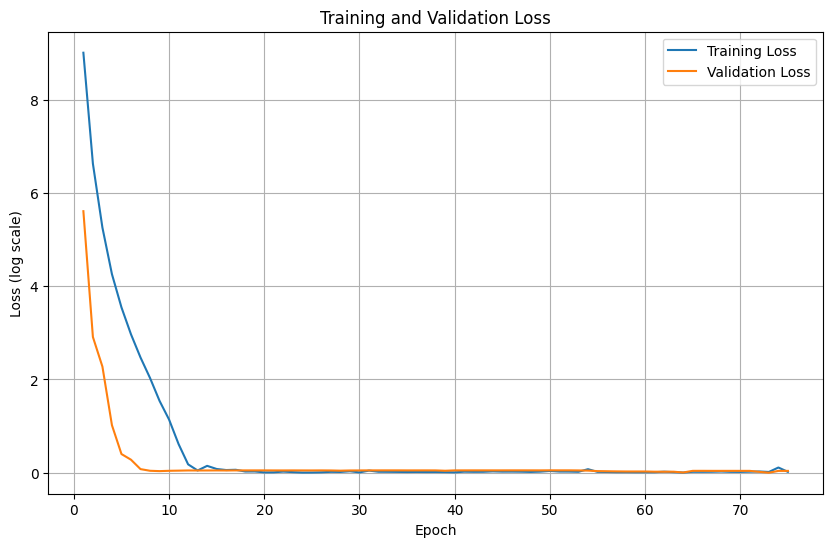

Test Loss: 1.0040
Test Accuracy: 50.32%


In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from NeuralNet import FeedForwardNN  # Import the FeedForwardNN class
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Define the model
input_size = X_train.shape[1]  # Number of features
hidden_sizes = [32, 64, 128]  # Hidden layer sizes
model = FeedForwardNN(input_size=input_size, hidden_sizes=hidden_sizes)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()  # For multi-class classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Initialize lists to log losses
train_losses = []
val_losses = []

# Training loop
num_epochs = 75
for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Validation phase
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()

    # Log losses
    train_losses.append(train_loss / len(train_loader))
    val_losses.append(val_loss / len(val_loader))

    # Print epoch results
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_losses[-1]:.4f}")
    print(f"Validation Loss: {val_losses[-1]:.4f}")
    print(f"Validation Accuracy: {100 * correct / total:.2f}%")

# Plot training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), np.log(train_losses), label='Training Loss')
plt.plot(range(1, num_epochs + 1), np.log(val_losses), label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (log scale)')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()
plt.show()

# Testing phase
model.eval()
test_loss = 0
correct = 0
total = 0
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += batch_y.size(0)
        correct += (predicted == batch_y).sum().item()

print(f"Test Loss: {test_loss / len(test_loader):.4f}")
print(f"Test Accuracy: {100 * correct / total:.2f}%")

# Interactive plot using Plotly
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=list(range(1, num_epochs + 1)),
    y=np.log(train_losses),
    name='Training Loss',
    mode='lines+markers'
))

fig.add_trace(go.Scatter(
    x=list(range(1, num_epochs + 1)),
    y=np.log(val_losses),
    name='Validation Loss',
    mode='lines+markers'
))

fig.update_layout(
    title='Training and Validation Loss (Interactive)',
    xaxis_title='Epoch',
    yaxis_title='Loss (log scale)',
    showlegend=True,
    hovermode='x unified'
)

fig.show()

### Now with PCA

In [6]:
# Load the new dataframe
new_df = pd.read_csv('new_dataframe.csv')

# Separate predictors and label
X_new = new_df.drop(columns=['koi_disposition'])
y_new = new_df['koi_disposition']

# Split into training and testing sets (80% train, 20% test)
X_new_train, X_new_temp, y_new_train, y_new_temp = train_test_split(X_new, y_new, test_size=0.2, random_state=42)

# Further split the testing set into validation and testing sets (50% of 20% each)
X_new_val, X_new_test, y_new_val, y_new_test = train_test_split(X_new_temp, y_new_temp, test_size=0.5, random_state=42)

# Convert pandas DataFrames/Series to PyTorch tensors
X_new_train_tensor = th.tensor(X_new_train.values, dtype=th.float32)
y_new_train_tensor = th.tensor(y_new_train.values, dtype=th.long)
X_new_val_tensor = th.tensor(X_new_val.values, dtype=th.float32)
y_new_val_tensor = th.tensor(y_new_val.values, dtype=th.long)
X_new_test_tensor = th.tensor(X_new_test.values, dtype=th.float32)
y_new_test_tensor = th.tensor(y_new_test.values, dtype=th.long)

# Create TensorDatasets
new_train_dataset = TensorDataset(X_new_train_tensor, y_new_train_tensor)
new_val_dataset = TensorDataset(X_new_val_tensor, y_new_val_tensor)
new_test_dataset = TensorDataset(X_new_test_tensor, y_new_test_tensor)

# Create DataLoaders
new_train_loader = DataLoader(new_train_dataset, batch_size=32, shuffle=True)
new_val_loader = DataLoader(new_val_dataset, batch_size=32, shuffle=False)
new_test_loader = DataLoader(new_test_dataset, batch_size=32, shuffle=False)

# Define the model
new_input_size = X_new_train.shape[1]  # Number of features
PCA_model = FeedForwardNN(input_size=new_input_size, hidden_sizes=hidden_sizes)

# Define the loss function and optimizer
new_criterion = nn.CrossEntropyLoss()
new_optimizer = optim.Adam(PCA_model.parameters(), lr=0.001, weight_decay = 1e-5)

# Define a learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(new_optimizer, step_size=50, gamma=0.1)

# Initialize lists to log losses
new_train_losses = []
new_val_losses = []

# New number of epochs
num_epochs = 300

# Training loop
for epoch in range(num_epochs):
    # Training phase
    PCA_model.train()
    new_train_loss = 0
    for batch_X, batch_y in new_train_loader:
        new_optimizer.zero_grad()
        outputs = PCA_model(batch_X)
        loss = new_criterion(outputs, batch_y)
        loss.backward()
        new_optimizer.step()
        new_train_loss += loss.item()

    # Validation phase
    PCA_model.eval()
    new_val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_X, batch_y in new_val_loader:
            outputs = PCA_model(batch_X)
            loss = new_criterion(outputs, batch_y)
            new_val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()

    # Log losses
    new_train_losses.append(new_train_loss / len(new_train_loader))
    new_val_losses.append(new_val_loss / len(new_val_loader))

    scheduler.step()  # Step the scheduler

    # Print epoch results
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {new_train_losses[-1]:.4f}")
    print(f"Validation Loss: {new_val_losses[-1]:.4f}")
    print(f"Validation Accuracy: {100 * correct / total:.2f}%")

# Testing phase
PCA_model.eval()
new_test_loss = 0
correct = 0
total = 0
with torch.no_grad():
    for batch_X, batch_y in new_test_loader:
        outputs = PCA_model(batch_X)
        loss = new_criterion(outputs, batch_y)
        new_test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += batch_y.size(0)
        correct += (predicted == batch_y).sum().item()

print()
print(f"Test Loss: {new_test_loss / len(new_test_loader):.4f}")
print(f"Test Accuracy: {100 * correct / total:.2f}%")

Epoch 1/300
Train Loss: 0.8019
Validation Loss: 0.5678
Validation Accuracy: 75.32%
Epoch 2/300
Train Loss: 0.5999
Validation Loss: 0.5320
Validation Accuracy: 76.48%
Epoch 3/300
Train Loss: 0.5582
Validation Loss: 0.5193
Validation Accuracy: 76.09%
Epoch 4/300
Train Loss: 0.5367
Validation Loss: 0.5134
Validation Accuracy: 76.74%
Epoch 5/300
Train Loss: 0.5310
Validation Loss: 0.5066
Validation Accuracy: 76.86%
Epoch 6/300
Train Loss: 0.5227
Validation Loss: 0.5011
Validation Accuracy: 76.99%
Epoch 7/300
Train Loss: 0.5158
Validation Loss: 0.5038
Validation Accuracy: 77.25%
Epoch 8/300
Train Loss: 0.5065
Validation Loss: 0.4956
Validation Accuracy: 76.86%
Epoch 9/300
Train Loss: 0.5068
Validation Loss: 0.4928
Validation Accuracy: 76.86%
Epoch 10/300
Train Loss: 0.4988
Validation Loss: 0.4883
Validation Accuracy: 77.38%
Epoch 11/300
Train Loss: 0.4922
Validation Loss: 0.4818
Validation Accuracy: 76.99%
Epoch 12/300
Train Loss: 0.4924
Validation Loss: 0.4803
Validation Accuracy: 77.89%
E

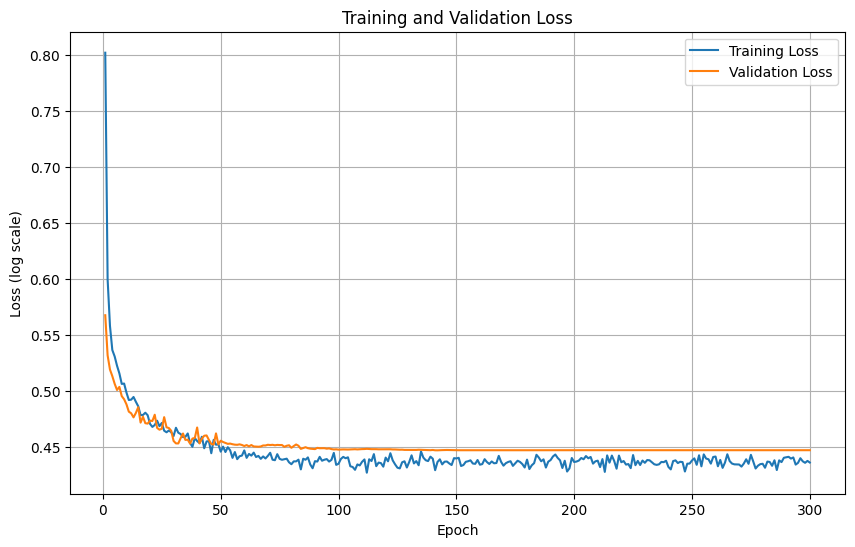

In [10]:
import matplotlib.pyplot as plt

# Plot training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), new_train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), new_val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (log scale)')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()
plt.show()

# Interactive plot using Plotly
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=list(range(1, num_epochs + 1)),
    y=np.log(train_losses),
    name='Training Loss',
    mode='lines+markers'
))

fig.add_trace(go.Scatter(
    x=list(range(1, num_epochs + 1)),
    y=np.log(val_losses),
    name='Validation Loss',
    mode='lines+markers'
))

fig.update_layout(
    title='Training and Validation Loss (Interactive)',
    xaxis_title='Epoch',
    yaxis_title='Loss (log scale)',
    showlegend=True,
    hovermode='x unified'
)

fig.show()

In [8]:
from sklearn.metrics import classification_report

# Function to evaluate a model
def evaluate_model(model, data_loader, y_true_tensor):
    model.eval()
    y_pred = []
    with torch.no_grad():
        for batch_X, _ in data_loader:
            outputs = model(batch_X)
            _, predicted = torch.max(outputs, 1)
            y_pred.extend(predicted.cpu().numpy())
    y_true = y_true_tensor.cpu().numpy()
    return classification_report(y_true, y_pred, target_names=['Class 0', 'Class 1', 'Class 2'])

# Evaluate PCA_model
print("Evaluation for PCA_model:")
print(evaluate_model(PCA_model, new_test_loader, y_new_test_tensor))

# Evaluate model
print("\nEvaluation for model:")
print(evaluate_model(model, test_loader, y_test_tensor))

Evaluation for PCA_model:
              precision    recall  f1-score   support

     Class 0       0.92      0.94      0.93       392
     Class 1       0.53      0.20      0.29       142
     Class 2       0.67      0.89      0.77       245

    accuracy                           0.79       779
   macro avg       0.71      0.68      0.66       779
weighted avg       0.77      0.79      0.76       779


Evaluation for model:
              precision    recall  f1-score   support

     Class 0       0.50      1.00      0.67       392
     Class 1       0.00      0.00      0.00       142
     Class 2       0.00      0.00      0.00       245

    accuracy                           0.50       779
   macro avg       0.17      0.33      0.22       779
weighted avg       0.25      0.50      0.34       779



/Users/kevinhan/opt/anaconda3/envs/babyRL/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kevinhan/opt/anaconda3/envs/babyRL/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kevinhan/opt/anaconda3/envs/babyRL/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

In [ ]:
# Evaluate the memory capacity of each model
import numpy as np
import torch
from sklearn.decomposition import PCA
import psutil
import os

def get_model_memory_usage(model):
    """
    Calculate the memory usage of a PyTorch model in bytes.
    
    Args:
        model: PyTorch model
        
    Returns:
        int: Memory usage in bytes
    """
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()
    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()
    
    return param_size + buffer_size

def get_pca_memory_usage(pca_model):
    """
    Calculate the memory usage of a scikit-learn PCA model in bytes.
    
    Args:
        pca_model: scikit-learn PCA model
        
    Returns:
        int: Memory usage in bytes
    """
    # Get size of components_
    components_size = pca_model.components_.nbytes if hasattr(pca_model, 'components_') else 0
    
    # Get size of explained_variance_
    variance_size = pca_model.explained_variance_.nbytes if hasattr(pca_model, 'explained_variance_') else 0
    
    # Get size of explained_variance_ratio_
    ratio_size = pca_model.explained_variance_ratio_.nbytes if hasattr(pca_model, 'explained_variance_ratio_') else 0
    
    # Get size of mean_
    mean_size = pca_model.mean_.nbytes if hasattr(pca_model, 'mean_') else 0
    
    return components_size + variance_size + ratio_size + mean_size

def format_bytes(bytes):
    """
    Format bytes into human readable format.
    
    Args:
        bytes: Number of bytes
        
    Returns:
        str: Formatted string
    """
    for unit in ['B', 'KB', 'MB', 'GB']:
        if bytes < 1024.0:
            return f"{bytes:.2f} {unit}"
        bytes /= 1024.0
    return f"{bytes:.2f} TB"

def get_process_memory_usage():
    """
    Get current process memory usage.
    
    Returns:
        int: Memory usage in bytes
    """
    process = psutil.Process(os.getpid())
    return process.memory_info().rss

def measure_memory_capacity(model, pca_model):
    """
    Measure and print memory capacity of both models.
    
    Args:
        model: PyTorch model
        pca_model: scikit-learn PCA model
    """
    # Get initial memory usage
    initial_memory = get_process_memory_usage()
    
    # Calculate model memory usage
    model_memory = get_model_memory_usage(model)
    pca_memory = get_pca_memory_usage(pca_model)
    
    # Get final memory usage
    final_memory = get_process_memory_usage()
    
    # Print results
    print("\nMemory Capacity Analysis:")
    print("-" * 30)
    print(f"Neural Network Model: {format_bytes(model_memory)}")
    print(f"PCA Model: {format_bytes(pca_memory)}")
    print(f"Total Model Memory: {format_bytes(model_memory + pca_memory)}")
    print(f"Process Memory Usage: {format_bytes(final_memory - initial_memory)}")
    print("-" * 30)

# Example usage:
if __name__ == "__main__":
    # Create example models
    class SimpleNN(torch.nn.Module):
        def __init__(self):
            super(SimpleNN, self).__init__()
            self.fc1 = torch.nn.Linear(100, 50)
            self.fc2 = torch.nn.Linear(50, 10)
    
    # Initialize models
    nn_model = SimpleNN()
    pca_model = PCA(n_components=10)
    
    # Fit PCA with dummy data
    dummy_data = np.random.rand(1000, 100)
    pca_model.fit(dummy_data)
    
    # Measure memory capacity
    measure_memory_capacity(nn_model, pca_model)